In [66]:
import pandas as pd
from pathlib import Path
MP_20_train = pd.read_csv("cdvae/data/mp_20/train.csv", index_col=0)

In [67]:
from pymatgen.io.cif import CifParser
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [68]:
from multiprocessing import Pool
def structure_from_cif(cif: str):
    return CifParser.from_str(cif).get_structures()[0]

def MP_to_pickle(MP_csv: Path):
    """
    Convert MP csv to pickle file
    """
    MP_csv = Path(MP_csv)
    MP_df = pd.read_csv(MP_csv, index_col=0)
    with Pool() as pool:
        MP_df["structure"] = pool.map(structure_from_cif, MP_df["cif"])
    MP_df.drop(columns=["cif"], inplace=True)
    MP_df.to_pickle(MP_csv.parent / (MP_csv.stem + ".pkl"))
    return MP_df

In [69]:
MP_20_train = MP_to_pickle("cdvae/data/mp_20/train.csv")
MP_20_test = MP_to_pickle("cdvae/data/mp_20/test.csv")
MP_20_val = MP_to_pickle("cdvae/data/mp_20/val.csv")

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/pymatgen/io/cif.py:1197: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/pymatgen/io/cif.py:1197: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/pymatgen/io/cif.py:1197: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues

In [71]:
from pymatgen.core import Structure
def structure_to_sites(structure: Structure):
    # Note(kazeevn):
    # We lose information about coordinates (as expected)
    # We also can't disabiguate between different orbits with same site symmetry
    # while the absolute coordinates might depend wholly on the unit cell choice (TBC), relatively to each other they are not
    analyzer = SpacegroupAnalyzer(structure)
    symmetry_dataset = analyzer.get_symmetry_dataset()
    # Whitespace usage in site_symmetry_symbols is inconsistent, so we remove it
    orbit_dict = dict(zip(symmetry_dataset['crystallographic_orbits'], map(lambda s: s.replace(" ", ""), symmetry_dataset['site_symmetry_symbols'])))
    element_dict = dict(zip(symmetry_dataset['crystallographic_orbits'], structure.species))

    return {
        "symmetry_sites": list(orbit_dict.values()),
        "symmetry_elements": list(element_dict.values()),
        "spacegroup_number": analyzer.get_space_group_number(),
    }

In [72]:
structure_to_sites(MP_20_test["structure"].iloc[0])

{'symmetry_sites': ['3m.', '3m.'],
 'symmetry_elements': [Element Ga, Element Te],
 'spacegroup_number': 194}

In [73]:
MP_20_test["structure"].iloc[0]

Structure Summary
Lattice
    abc : 4.134599999326192 4.13459945 18.42557
 angles : 90.0 89.99999999999999 120.00000439499999
 volume : 272.7837447071836
      A : -2.0673002743262288 -3.5806684753267577 -5.063423982198906e-16
      B : -2.067299175673771 3.5806684753267577 2.531711991099453e-16
      C : 0.0 0.0 -18.42557
    pbc : True True True
PeriodicSite: Ga0 (Ga) (-2.067, -1.194, -15.05) [0.6667, 0.3333, 0.817]
PeriodicSite: Ga1 (Ga) (-2.067, 1.194, -5.842) [0.3333, 0.6667, 0.317]
PeriodicSite: Ga2 (Ga) (-2.067, 1.194, -3.371) [0.3333, 0.6667, 0.183]
PeriodicSite: Ga3 (Ga) (-2.067, -1.194, -12.58) [0.6667, 0.3333, 0.683]
PeriodicSite: Te4 (Te) (-2.067, -1.194, -2.097) [0.6667, 0.3333, 0.1138]
PeriodicSite: Te5 (Te) (-2.067, 1.194, -11.31) [0.3333, 0.6667, 0.6138]
PeriodicSite: Te6 (Te) (-2.067, 1.194, -16.33) [0.3333, 0.6667, 0.8862]
PeriodicSite: Te7 (Te) (-2.067, -1.194, -7.116) [0.6667, 0.3333, 0.3862]

In [74]:
analyzer = SpacegroupAnalyzer(MP_20_test["structure"].iloc[0])

In [75]:
analyzer.get_symmetry_dataset()['site_symmetry_symbols']

['3m.', '3m.', '3m.', '3m.', '3m.', '3m.', '3m.', '3m.']

In [76]:
# get the spacegroup number
analyzer.get_space_group_number()

194

In [77]:
analyzer.get_symmetry_dataset()['origin_shift']

array([-1.11022302e-16, -1.11022302e-16,  0.00000000e+00])

In [78]:
analyzer.get_symmetrized_structure()

SymmetrizedStructure
Full Formula (Ga4 Te4)
Reduced Formula: GaTe
Spacegroup: P6_3/mmc (194)
abc   :   4.134600   4.134599  18.425570
angles:  90.000000  90.000000 120.000004
Sites (8)
  #  SP           a         b         c  Wyckoff
---  ----  --------  --------  --------  ---------
  0  Ga    0.666667  0.333333  0.817041  4f
  1  Te    0.666667  0.333333  0.113796  4f

In [79]:
from pyxtal.symmetry import Group
g = Group(194)

In [80]:
Group(194).Wyckoff_positions[6]

Wyckoff position 4f in space group 194 with site symmetry 3 m m
1/3, 2/3, z
2/3, 1/3, z+1/2
2/3, 1/3, -z
1/3, 2/3, -z+1/2

In [81]:
from multiprocessing import Pool
for dataset in (MP_20_train, MP_20_test, MP_20_val):
    with Pool() as p:
        symmetry_dataset = pd.DataFrame.from_records(p.map(structure_to_sites, dataset['structure'])).set_index(dataset.index)
    dataset.loc[:, symmetry_dataset.columns] = symmetry_dataset

spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 0 tolerance = 1.000000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 1 tolerance = 9.500000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 2 tolerance = 9.025000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 3 tolerance = 8.573750e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 0 tolerance = 1.000000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 1 tolerance = 9.500000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 4

In [17]:
# pad the lists to ease the batching
from pymatgen.core import DummySpecie
max_len = max([len(x) for x in MP_20_train['symmetry_sites']])
for dataset in (MP_20_train, MP_20_test, MP_20_val):
    dataset['symmetry_sites'] = [x + ["PAD"] * (max_len - len(x)) for x in dataset['symmetry_sites']]
    dataset['symmetry_elements'] = [x + [DummySpecie()] * (max_len - len(x)) for x in dataset['symmetry_elements']]
    dataset['padding_mask'] = [[False] * len(x) + [True] * (max_len - len(x)) for x in dataset['symmetry_sites']]
print(max_len)

20


In [18]:
MP_20_train.iloc[0]

material_id                                                         mp-1221227
formation_energy_per_atom                                             -1.63746
band_gap                                                                0.2133
pretty_formula                                                     Na3MnCoNiO6
e_above_hull                                                          0.043001
elements                                         ['Co', 'Mn', 'Na', 'Ni', 'O']
spacegroup.number                                                            8
structure                    [[-2.13163694 -1.97863317 -0.78933557] Na, [-1...
symmetry_sites               [m, m, m, m, m, m, m, m, m, m, m, m, PAD, PAD,...
symmetry_elements            [Na, Na, Na, Mn, Co, Ni, O, O, O, O, O, O, X0+...
spacegroup_number                                                            8
padding_mask                 [False, False, False, False, False, False, Fal...
Name: 37228, dtype: object

In [19]:
from itertools import chain
all_sites = set(chain(*MP_20_train['symmetry_sites'].values,*MP_20_test['symmetry_sites'].values, *MP_20_val['symmetry_sites'].values))
all_elements = set(chain(*MP_20_train['symmetry_elements'].values,*MP_20_test['symmetry_elements'].values, *MP_20_val['symmetry_elements'].values))
all_symmetry_groups = set(chain(MP_20_train['spacegroup_number'].values,MP_20_test['spacegroup_number'].values, MP_20_val['spacegroup_number'].values))
# In order to make conditional prediction of sites on elements, we need to make a predicion of site by
# N sites, and (N+1) elements
MASK_SITE = "MASK_SITE"
all_sites.add(MASK_SITE)

In [20]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

In [21]:
site_to_ids = {word: idx for idx, word in enumerate(all_sites)}
element_to_ids = {word: idx for idx, word in enumerate(all_elements)}
MASK_ID = site_to_ids[MASK_SITE]
def sites_to_tensor(sites):
    return torch.tensor([site_to_ids[site] for site in sites])
def element_to_tensor(elements):
    return torch.tensor([element_to_ids[element] for element in elements])
for dataset in (MP_20_train, MP_20_test, MP_20_val):
    dataset['symmetry_sites_tensor'] = dataset['symmetry_sites'].map(sites_to_tensor)
    dataset['symmetry_elements_tensor'] = dataset['symmetry_elements'].map(element_to_tensor)
    dataset['spacegroup_number_tensor'] = dataset['spacegroup_number'].map(torch.tensor)

In [22]:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class WyckoffTransformerModel(nn.Module):

    def __init__(self, n_space_groups: int, n_sites: int, n_elements: int, d_space_groups: int, d_sites: int, d_species: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        # We are going to concatenate the site, the element, and the space group
        self.d_model = d_sites + d_species + d_space_groups
        self.n_token = n_sites + n_elements
        self.n_elements = n_elements
        encoder_layers = TransformerEncoderLayer(self.d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.sites_embedding = nn.Embedding(n_sites, d_sites)
        self.species_embedding = nn.Embedding(n_elements, d_species)
        self.space_groups_embedding = nn.Embedding(n_space_groups, d_space_groups)
        # We predict both the site and the element
        # However! They can not be sampled independently!
        # We are going to condition site on the element,
        # so that we can attempt CSP
        # The question of autoregressive construction order is still open though
        # An option would be to first sort by element, and then by site multiplicity
        self.linear = nn.Linear(self.d_model, self.n_token)
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        # CONSIDER(kazeevn) using the site symmetry matrices to initialize the site embeddings
        # and some inforamtion about the element to initialize the element embeddings
        self.sites_embedding.weight.data.uniform_(-initrange, initrange)
        self.species_embedding.weight.data.uniform_(-initrange, initrange)
        self.space_groups_embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, space_group: Tensor, sites: Tensor, species: Tensor) -> (Tensor, Tensor):
        """
        Arguments:
            space_group: Tensor of shape ``[batch_size]``
            sites: Tensor, shape ``[seq_len, batch_size]``
            species: Tensor, shape ``[seq_len, batch_size]``

        Returns:
            Tensor of shape ``[seq_len, batch_size, n_elements]``
            Tensor of shape ``[seq_len, batch_size, n_sites]``
            Remember not to train via independent sampling!
        """
        # And here is a good question on masking
        # 1. Padding. If we just mask it, the model won't be able to stop predicting, we'll need to additinally introduce a stop token.
        # probably, can do without for now. The previous iteration reliably predicted sequences of PADs
        # 2. Casual masking. We can't use it as is, as we need the model to attend on the element of the site
        src = torch.concat([self.sites_embedding(sites), self.species_embedding(species),
                            self.space_groups_embedding(torch.tile(space_group, (sites.shape[0], 1)))], dim=2) * math.sqrt(self.d_model)
        output = self.transformer_encoder(src, None)
        output = self.linear(output)
        return output[:, :, :self.n_elements], output[:, :, self.n_elements:]

In [23]:
torch.stack(tuple(dataset['symmetry_sites_tensor'].values)).T.shape

torch.Size([20, 9047])

In [24]:
torch.stack(tuple(dataset['symmetry_elements_tensor'].values)).T.shape

torch.Size([20, 9047])

In [25]:
MP_20_train

,material_id,formation_energy_per_atom,band_gap,pretty_formula,e_above_hull,elements,spacegroup.number,structure,symmetry_sites,symmetry_elements,spacegroup_number,padding_mask,symmetry_sites_tensor,symmetry_elements_tensor,spacegroup_number_tensor
37228,mp-1221227,-1.637460,0.2133,Na3MnCoNiO6,0.043001,"['Co', 'Mn', 'Na', 'Ni', 'O']",8,"[[-2.13163694 -1.97863317 -0.78933557] Na, [-1...","[m, m, m, m, m, m, m, m, m, m, m, m, PAD, PAD,...","[Na, Na, Na, Mn, Co, Ni, O, O, O, O, O, O, X0+...",8,"[False, False, False, False, False, False, Fal...","[tensor(37), tensor(37), tensor(37), tensor(37...","[tensor(10), tensor(10), tensor(10), tensor(24...",tensor(8)
19480,mp-974729,-0.314759,0.0000,Nd(Al2Cu)4,0.000000,"['Al', 'Cu', 'Nd']",139,"[[0. 0. 0.] Nd, [7.81740995 6.73412703 1.55353...","[4/mmm, m2m., m2m., ..2/m, PAD, PAD, PAD, PAD,...","[Nd, Al, Al, Cu, X0+, X0+, X0+, X0+, X0+, X0+,...",139,"[False, False, False, False, False, False, Fal...","[tensor(20), tensor(17), tensor(17), tensor(26...","[tensor(59), tensor(12), tensor(12), tensor(28...",tensor(139)
29624,mp-1185360,-0.193761,0.0000,LiMnIr2,0.018075,"['Ir', 'Li', 'Mn']",225,[[2.22044605e-16 5.10035615e+00 4.44089210e-16...,"[m-3m, m-3m, -43m, PAD, PAD, PAD, PAD, PAD, PA...","[Li, Mn, Ir, X0+, X0+, X0+, X0+, X0+, X0+, X0+...",225,"[False, False, False, False, False, False, Fal...","[tensor(39), tensor(39), tensor(58), tensor(70...","[tensor(2), tensor(24), tensor(76), tensor(89)...",tensor(225)
38633,mp-1188861,-0.584694,3.8556,LiCSN,0.048847,"['C', 'Li', 'N', 'S']",62,"[[ 0.96469575 2.34470985 11.12401327] Li, [0....","[.m., .m., .m., .m., PAD, PAD, PAD, PAD, PAD, ...","[Li, C, S, N, X0+, X0+, X0+, X0+, X0+, X0+, X0...",62,"[False, False, False, False, False, False, Fal...","[tensor(64), tensor(64), tensor(64), tensor(64...","[tensor(2), tensor(5), tensor(15), tensor(6), ...",tensor(62)
10889,mp-677272,-2.474759,0.4707,La2EuS4,0.000000,"['Eu', 'La', 'S']",122,"[[ 0.03187948 -4.65810216 -3.8370089 ] La, [ 2...","[.2., -4.., 1, PAD, PAD, PAD, PAD, PAD, PAD, P...","[La, Eu, S, X0+, X0+, X0+, X0+, X0+, X0+, X0+,...",122,"[False, False, False, False, False, False, Fal...","[tensor(3), tensor(10), tensor(63), tensor(70)...","[tensor(56), tensor(62), tensor(15), tensor(89...",tensor(122)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37856,mp-568116,-0.988502,3.7614,Lu2(CN2)3,0.045185,"['C', 'Lu', 'N']",155,"[[ -5.91256226 -4.2054885 -10.08353932] Lu, ...","[3., .2, 1, PAD, PAD, PAD, PAD, PAD, PAD, PAD,...","[Lu, C, N, X0+, X0+, X0+, X0+, X0+, X0+, X0+, ...",155,"[False, False, False, False, False, False, Fal...","[tensor(7), tensor(65), tensor(63), tensor(70)...","[tensor(70), tensor(5), tensor(6), tensor(89),...",tensor(155)
11955,mp-865529,-0.640955,0.0000,Ti2NiIr,0.000000,"['Ti', 'Ni', 'Ir']",225,[[-5.56588028e-17 7.95918309e+00 6.66133815e...,"[-43m, m-3m, m-3m, PAD, PAD, PAD, PAD, PAD, PA...","[Ti, Ni, Ir, X0+, X0+, X0+, X0+, X0+, X0+, X0+...",225,"[False, False, False, False, False, False, Fal...","[tensor(58), tensor(39), tensor(39), tensor(70...","[tensor(21), tensor(27), tensor(76), tensor(89...",tensor(225)
26119,mp-1189241,-0.756019,0.0000,GdAs2Au,0.010305,"['As', 'Au', 'Gd']",64,"[[-1.01899694 3.03490852 -3.17157209] As, [-3...","[4mm, -4m2, -4m2, 4mm, PAD, PAD, PAD, PAD, PAD...","[As, As, Au, Gd, X0+, X0+, X0+, X0+, X0+, X0+,...",129,"[False, False, False, False, False, False, Fal...","[tensor(38), tensor(55), tensor(55), tensor(38...","[tensor(32), tensor(32), tensor(78), tensor(63...",tensor(129)
30556,mp-1104538,-0.104870,0.0000,Tm(FeSn)6,0.021206,"['Fe', 'Sn', 'Tm']",191,"[[0. 0. 0.] Tm, [-1.352999 -2.34346301 -2.19...","[6/mmm, 2mm, -6m2, -6m2, 6mm, PAD, PAD, PAD, P...","[Tm, Fe, Sn, Sn, Sn, X0+, X0+, X0+, X0+, X0+, ...",191,"[False, False, False, False, False, False, Fal...","[tensor(46), tensor(66), tensor(22), tensor(22...","[tensor(68), tensor(25), tensor(49), tensor(49...",tensor(191)


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# TODO batch dimension to 1
def to_combined_dataset(dataset):
    return dict(
        symmetry_sites=torch.stack(tuple(dataset['symmetry_sites_tensor'].values)).T.to(device),
        symmetry_elements=torch.stack(tuple(dataset['symmetry_elements_tensor'].values)).T.to(device),
        spacegroup_number=torch.stack(tuple(dataset['spacegroup_number_tensor'])).to(device)
    )
torch_datasets = {
    "train": to_combined_dataset(MP_20_train),
    "val": to_combined_dataset(MP_20_val),
    "test": to_combined_dataset(MP_20_test),
}

In [27]:
torch_datasets["train"]["spacegroup_number"].shape

torch.Size([27136])

In [28]:
# Consider each structure to be a batch
# CONSIDER proper batching
train_batch_size = torch_datasets["train"]['symmetry_sites'].shape[1]

In [29]:
MASK_ID_TENSOR = torch.tensor(MASK_ID).to(device)
ELEMENT_PAD_ID_TENSOR = torch.tensor(element_to_ids[DummySpecie()]).to(device)
def get_batches(symmetry_sites: Tensor, symmetry_elements:Tensor, element_seq_len: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        element_seq_len: number of elements considered known
    Returns:
        Two pairs of (data, target):
        1. The first is to predict the element given i sites and elements
        2. The second is to predict the site given i sites and i+1 elements
        
    """
    # Can't predict past the last token
    assert element_seq_len < symmetry_elements.shape[0]
    # Predict element number element_seq_len + 1
    data_element = {
        "sites": symmetry_sites[0:element_seq_len],
        "species": symmetry_elements[0:element_seq_len]
    }
    target_element = symmetry_elements[1:1+element_seq_len]#.reshape(-1)

    # Predict site number element_seq_len + 1
    # For sites, we condition on species, hence the + 1  in species
    data_site = {
        "sites": torch.cat([symmetry_sites[0:element_seq_len], MASK_ID_TENSOR.expand(1, symmetry_sites.shape[1])], dim=0),
        "species": symmetry_elements[0:element_seq_len + 1]
    }
    target_site = symmetry_sites[0:1+element_seq_len]#.reshape(-1)
    return ((data_element, target_element), (data_site, target_site))

In [30]:
get_batches(torch_datasets["train"]['symmetry_sites'], torch_datasets["train"]['symmetry_elements'], 0)[1][0]["sites"].shape

torch.Size([1, 27136])

In [31]:
get_batches(torch_datasets["train"]['symmetry_sites'], torch_datasets["train"]['symmetry_elements'], 0)[0][0]["sites"].shape

torch.Size([0, 27136])

In [32]:
get_batches(torch_datasets["train"]['symmetry_sites'], torch_datasets["train"]['symmetry_elements'], 19)[1][0]["sites"].shape

torch.Size([20, 27136])

In [33]:
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
n_space_groups = max(all_symmetry_groups) + 1
assert n_space_groups == 230
model = WyckoffTransformerModel(
    n_space_groups = n_space_groups,
    n_sites = len(site_to_ids),
    n_elements = len(element_to_ids),
    d_space_groups=16, # Intuitition: 4x4 matrix
    d_sites = 100,
    d_species = 100,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout).to(device)

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [34]:
import time
bptt = max_len

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def get_loss(model, dataset, known_seq_len):
    (data_element, target_element), (data_site, target_site) = get_batches(dataset["symmetry_sites"],
                                                                           dataset["symmetry_elements"], known_seq_len)
    output_element = model(dataset["spacegroup_number"], **data_element)[0]
    loss_element = criterion(output_element.flatten().view(-1, len(element_to_ids)), target_element.flatten())
    output_site = model(dataset["spacegroup_number"], **data_site)[1]
    loss_site = criterion(output_site.flatten().view(-1, len(site_to_ids)), target_site.flatten())
    loss = loss_element + loss_site
    return loss

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    for known_seq_len in range(1, max_len):
        loss = get_loss(model, torch_datasets["train"], known_seq_len)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        
        lr = scheduler.get_last_lr()[0]
        ms_per_batch = (time.time() - start_time) * 1000 / log_interval
        cur_loss = total_loss / log_interval
        ppl = math.exp(cur_loss)
        print(f'| epoch {epoch:3d} | '
                f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
        total_loss = 0
        start_time = time.time()

def evaluate(model: nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for known_seq_len in range(max_len):
            loss = get_loss(model, torch_datasets["val"], known_seq_len)
            total_loss += loss
    return total_loss / (len( torch_datasets["val"]["symmetry_sites"]) - 1)

In [35]:
best_val_loss = float('inf')
epochs = 60

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path))

| epoch   1 | lr 5.00 | ms/batch  3.22 | loss  0.05 | ppl     1.05
| epoch   1 | lr 5.00 | ms/batch  0.52 | loss  0.04 | ppl     1.04
| epoch   1 | lr 5.00 | ms/batch  0.64 | loss  0.04 | ppl     1.04
| epoch   1 | lr 5.00 | ms/batch  0.77 | loss  0.02 | ppl     1.03
| epoch   1 | lr 5.00 | ms/batch  0.90 | loss  0.03 | ppl     1.03
| epoch   1 | lr 5.00 | ms/batch  1.04 | loss  0.02 | ppl     1.02
| epoch   1 | lr 5.00 | ms/batch  1.18 | loss  0.06 | ppl     1.06
| epoch   1 | lr 5.00 | ms/batch  1.33 | loss  0.01 | ppl     1.01
| epoch   1 | lr 5.00 | ms/batch  1.46 | loss  0.03 | ppl     1.03
| epoch   1 | lr 5.00 | ms/batch  1.59 | loss  0.01 | ppl     1.01
| epoch   1 | lr 5.00 | ms/batch  1.73 | loss  0.02 | ppl     1.02
| epoch   1 | lr 5.00 | ms/batch  1.87 | loss  0.02 | ppl     1.02
| epoch   1 | lr 5.00 | ms/batch  2.00 | loss  0.01 | ppl     1.01
| epoch   1 | lr 5.00 | ms/batch  2.14 | loss  0.01 | ppl     1.01
| epoch   1 | lr 5.00 | ms/batch  2.27 | loss  0.01 | ppl     

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp1qo0q8h2/best_model_params.pt'

In [36]:
space_groups.shape

NameError: name 'space_groups' is not defined

In [37]:
#def get_batches(symmetry_sites: Tensor, symmetry_elements:Tensor, element_seq_len: int) -> Tuple[Tensor, Tensor]:
d1, t1 = get_batches(torch_datasets["train"]["symmetry_sites"], torch_datasets["train"]["symmetry_elements"], 0)[0]

In [38]:
t1

tensor([], device='cuda:0', size=(0, 27136), dtype=torch.int64)

In [39]:
torch_datasets["test"]["symmetry_sites"][[0]]

tensor([[35, 11,  6,  ..., 63, 10, 52]], device='cuda:0')

In [40]:
model(torch_datasets["train"]["spacegroup_number"], d1['sites'], d1['species'])

(tensor([], device='cuda:0', size=(0, 27136, 90), grad_fn=<SliceBackward0>),
 tensor([], device='cuda:0', size=(0, 27136, 74), grad_fn=<SliceBackward0>))

In [41]:
from torch.nn.functional import softmax
model.eval()
space_groups = torch_datasets["test"]["spacegroup_number"]
sites = torch_datasets["test"]["symmetry_sites"][[0]]
elements = torch_datasets["test"]["symmetry_elements"][[0]]
for i in range(max_len - 3):
    probas_elements = softmax(model(space_groups, sites, elements)[0], -1)
    next_elemenets = torch.multinomial(probas_elements[-1], 1).T
    elements = torch.cat((elements, next_elemenets), 0)

    masked_sites = torch.cat([sites, MASK_ID_TENSOR.expand(1, sites.shape[1])], dim=0)
    probas_sites = softmax(model(space_groups, masked_sites, elements)[1], -1)
    next_sites = torch.multinomial(probas_sites[-1], 1).T
    sites = torch.cat((sites, next_sites), 0)

In [42]:
idx_to_element = {idx: element for element, idx in element_to_ids.items()}
idx_to_site = {idx: site for site, idx in site_to_ids.items()}

In [43]:
PAD_ID = site_to_ids["PAD"]

In [44]:
ELEMENT_PAD_ID = element_to_ids[DummySpecie()]

In [45]:
generated_structuers = []
for this_elements, this_sites, this_spacegroup in zip(elements.T, sites.T, space_groups):
    sites_str = []
    elements_str = []
    for i in range(len(this_sites)):
      if this_sites[i] == PAD_ID or this_elements[i] == ELEMENT_PAD_ID:
        break
      sites_str.append(idx_to_site[int(this_sites[i])])
      elements_str.append(idx_to_element[int(this_elements[i])])
    generated_structuers.append({
        "spacegroup": int(this_spacegroup),
        "sites": sites_str,
        "elements": elements_str
    })

In [46]:
generated_structuers[0]

{'spacegroup': 194,
 'sites': ['3m.', '-6m2', 'mm2', 'mm2', '3m.', '-6m2', '-6m2'],
 'elements': [Element Ga,
  Element Ga,
  Element Ga,
  Element Ga,
  Element Ga,
  Element Ga,
  Element Ga]}

In [47]:
sites[:, 0]

tensor([35, 22, 52, 52, 35, 22, 22, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70],
       device='cuda:0')

In [48]:
from collections import defaultdict
index = dict()
wp_index = defaultdict(dict)
for group_number in range(1, 231):
    group = Group(group_number)
    site_symmetry_symbols = []
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()  
        site_symmetry_symbols.append(wp.site_symm)
        wp_index[group_number][wp.site_symm.replace(" ", "")] = (wp.multiplicity, wp.letter)

In [49]:
import pyxtal
generator = pyxtal.pyxtal()

In [50]:
total = 0
valid = 0
valid_structures = []
for example in generated_structuers:
    total += 1
    T_sites_list = []
    try:
        # print(wp_index[example["space_group"]])
        mutliplicity = []
        for site, element in zip(example['sites'], example['elements']):
            mutliplicity.append(wp_index[example["spacegroup"]][site][0])
            T_sites_list.append([str(wp_index[example["spacegroup"]][site][0])+wp_index[example["spacegroup"]][site][1]])
        valid += 1
        T_spacegroup = example['spacegroup']
        valid_structures.append({
            "spacegroup": T_spacegroup,
            "sites": T_sites_list,
            "elements": list(map(str, example['elements'])),
            "multiplicity": mutliplicity
        })
    except KeyError:
        pass

In [64]:
print(valid, total)

1993 9046


In [84]:
MP_20_test.head()

,material_id,formation_energy_per_atom,band_gap,pretty_formula,e_above_hull,elements,spacegroup.number,structure,symmetry_sites,symmetry_elements,spacegroup_number
6000,mp-10009,-0.575092,0.898,GaTe,0.000000,"['Ga', 'Te']",194,"[[ -2.06729991 -1.19355616 -15.05444614] Ga, ...","[3m., 3m.]","[Ga, Te]",194
37702,mp-1218989,-0.942488,0.000,SmThCN,0.044109,"['C', 'N', 'Sm', 'Th']",160,"[[ 3.8798713 2.3784524 -6.40259234] Sm, [ 1...","[3m, 3m, 3m, 3m]","[Sm, Th, C, N]",160
42245,mp-1225695,0.064863,0.000,CuNi,0.064863,"['Cu', 'Ni']",65,"[[ 0.70102159 1.10647765 -2.0703265 ] Cu, [0....","[mmm, mmm]","[Cu, Ni]",65
780,mp-1220884,-1.456116,0.000,NaTiVS4,0.000000,"['Na', 'S', 'Ti', 'V']",8,"[[-3.09449963 -2.52105024 4.88770116] Na, [ 0...","[m, m, m, m, m, m, m]","[Na, Ti, V, S, S, S, S]",8
35749,mp-1224266,0.024139,0.000,Ho3TmMn8,0.036496,"['Ho', 'Mn', 'Tm']",8,"[[-4.99716986 3.05327099 4.08392049] Ho, [-4...","[m, m, m, m, m, m, 1, m, 1, m]","[Ho, Ho, Ho, Tm, Mn, Mn, Mn, Mn, Mn, Mn]",8


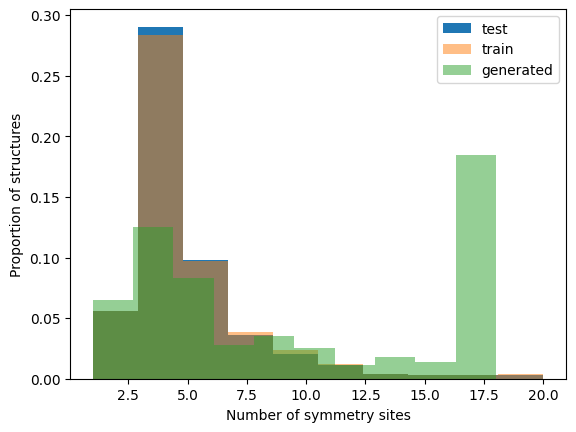

In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(MP_20_test.symmetry_sites.map(len), label="test", density=True)
ax.hist(MP_20_train.symmetry_sites.map(len), label="train", density=True, alpha=0.5)
ax.hist(list(map(lambda s: len(s["elements"]), valid_structures)), label="generated", density=True, alpha=0.5)
ax.set_xlabel("Number of symmetry sites")
ax.set_ylabel("Proportion of structures")
ax.legend();

In [89]:
valid_structures

[{'spacegroup': 194,
  'sites': [['4e'], ['12k']],
  'elements': ['Zr', 'Pb'],
  'multiplicity': [4, 12]},
 {'spacegroup': 156,
  'sites': [['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a'],
   ['1a']],
  'elements': ['Ta',
   'Ta',
   'Ta',
   'Ta',
   'Ta',
   'Ta',
   'Ta',
   'Ta',
   'Ta',
   'Ta',
   'Ta',
   'Se',
   'Se',
   'S',
   'S',
   'S',
   'S',
   'S'],
  'multiplicity': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'spacegroup': 14,
  'sites': [['4e'], ['4e'], ['4e'], ['4e'], ['4e'], ['4e'], ['4e']],
  'elements': ['Eu', 'B', 'B', 'B', 'B', 'Ir', 'Ir'],
  'multiplicity': [4, 4, 4, 4, 4, 4, 4]},
 {'spacegroup': 63,
  'sites': [['8g'], ['4c'], ['4c'], ['4c'], ['4c'], ['4c'], ['4c'], ['8f']],
  'elements': ['Ca', 'Ca', 'Bi', 'Bi', 'Te', 'Mo', 'Pt', 'O'],
  'multiplicity': [8, 4, 4, 4, 4, 4, 4, 8]},
 {'spacegroup': 44,
  'sites'

In [ ]:
ax.hist(list(map(lambda s: len(s["elements"]), valid_structures)), label="generated", density=True, alpha=0.5)

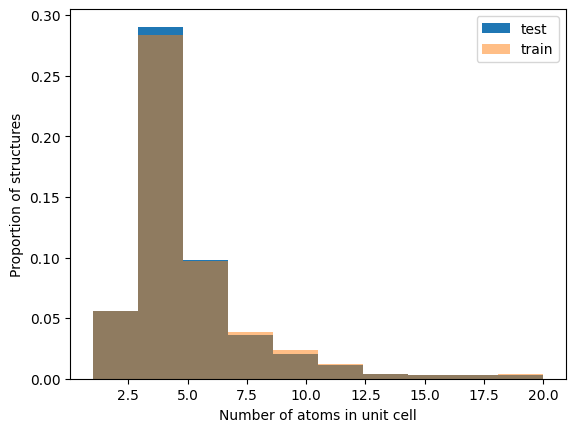

In [86]:
fig, ax = plt.subplots()
ax.hist(MP_20_test.symmetry_elements.map(len), label="test", density=True)
ax.hist(MP_20_train.symmetry_elements.map(len), label="train", density=True, alpha=0.5)
#ax.hist(list(map(lambda s: len(s["elements"]), valid_structures)), label="generated", density=True, alpha=0.5)
ax.set_xlabel("Number of atoms in unit cell")
ax.set_ylabel("Proportion of structures")
ax.legend();

In [55]:
example = valid_structures[0]
example

{'spacegroup': 194,
 'sites': [['4e'], ['12k']],
 'elements': ['Zr', 'Pb'],
 'multiplicity': [4, 12]}

In [56]:
# TODO pass tm and consider learning it
# Consider 1.5*covalent
generator.from_random(3, group=example["spacegroup"], species=example["elements"],
                      numIons=example["multiplicity"], sites=example["sites"])

In [57]:
ase_struct = generator.to_ase()

In [58]:
import ase.visualize
ase.visualize.view(ase_struct, viewer="ngl")

In [456]:
group = Group(61)
for wp in group.Wyckoff_positions:
    wp.get_site_symmetry()

In [386]:
group.Wyckoff_positions[0].get_site_symmetry()

In [387]:
group.Wyckoff_positions[0].site_symm

'1'

In [364]:
a is None

False

In [366]:
a.site_symm

'1'

In [330]:
        # index  is hall number
        #indices[0] = position_wyckoff[index];
        #indices[1] = position_wyckoff[index + 1] - position_wyckoff[index];

In [332]:
#                 ssmdb_get_site_symmetry_symbol(site_sym_symbol,
                                               #indices_wyc[0] + i);

In [342]:
from collections import defaultdict
sites = defaultdict(list)
for hall_number in range(len(position_wyckoff) - 1):
    for i in range(spg_db.position_wyckoff[hall_number], spg_db.position_wyckoff[hall_number + 1]):
        sites[hall_number].append(spg_db.site_symmetry[i].rstrip())

In [343]:
sites

defaultdict(list,
            {0: [''],
             1: ['1'],
             2: ['1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1'],
             3: ['1', '2', '2', '2', '2'],
             4: ['1', '2', '2', '2', '2'],
             5: ['1', '2', '2', '2', '2'],
             6: ['1'],
             7: ['1'],
             8: ['1'],
             9: ['1', '2', '2'],
             10: ['1', '2', '2'],
             11: ['1', '2', '2'],
             12: ['1', '2', '2'],
             13: ['1', '2', '2'],
             14: ['1', '2', '2'],
             15: ['1', '2', '2'],
             16: ['1', '2', '2'],
             17: ['1', '2', '2'],
             18: ['1', 'm', 'm'],
             19: ['1', 'm', 'm'],
             20: ['1', 'm', 'm'],
             21: ['1'],
             22: ['1'],
             23: ['1'],
             24: ['1'],
             25: ['1'],
             26: ['1'],
             27: ['1'],
             28: ['1'],
             29: ['1'],
             30: ['1', 'm'],
             31:

In [348]:
from pyxtal.symmetry import Group, Wyckoff_position

In [354]:
Group(2)

-- Spacegroup --# 2 (P-1)--
2i	site symm: 1
1h	site symm: -1
1g	site symm: -1
1f	site symm: -1
1e	site symm: -1
1d	site symm: -1
1c	site symm: -1
1b	site symm: -1
1a	site symm: -1

In [347]:
s.from_random()

TypeError: unsupported format string passed to NoneType.__format__

In [327]:
len(spg_db.site_symmetry)

4096

In [ ]:
pyxtal.pyxtal.from_random()

In [308]:
spglib.get_symmetry_from_database(hall_number=2)

{'rotations': array([[[ 1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0,  1]],
 
        [[-1,  0,  0],
         [ 0, -1,  0],
         [ 0,  0, -1]]], dtype=int32),
 'translations': array([[0., 0., 0.],
        [0., 0., 0.]])}

In [298]:
spglib.__file__

'/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/spglib/__init__.py'

In [265]:
next_tokens.shape

torch.Size([13, 1])

In [284]:
sequences.shape

torch.Size([3, 13])

In [278]:
probas[-1].shape

torch.Size([13, 73])

In [221]:
start

tensor([66, 24, 32, 40, 64, 32, 63, 44, 16, 65, 18, 60, 30], device='cuda:0')

In [259]:
get_batch(train_data[:, :4],18)[0].shape

torch.Size([1, 4])

In [226]:
output

tensor([[-1.1501e-01, -1.0813e+00, -2.8277e-01, -8.8878e-01,  9.6309e-01,
         -1.4374e+00,  4.8899e+00,  5.3303e-01, -1.6858e-02, -1.2647e+00,
         -1.8436e+00, -2.0023e-01,  4.5401e-01, -1.9268e+00,  1.0780e+00,
         -7.8715e-01, -1.3936e+00,  7.1426e-01,  1.3526e+00, -8.7893e-01,
         -8.2050e-01, -3.6213e-01, -9.9722e-01,  6.1405e-01, -6.3549e-01,
         -5.5356e-01, -5.1126e-03, -9.6416e-01, -5.6719e-01,  2.0959e+00,
          3.0051e+00,  1.7029e+00,  2.6258e+00, -1.0740e+00,  7.6692e-01,
          1.1560e+00, -9.3513e-01, -2.0610e+00, -8.9891e-01,  1.2618e+00,
         -4.2852e-01, -2.1445e-01, -9.1498e-01, -8.1692e-01, -9.3644e-01,
          4.3205e-01,  1.7107e-01,  4.1742e-01, -1.6240e-01, -2.1882e-01,
          1.7070e+00,  4.0800e-01, -2.7730e-02,  1.4231e+00, -8.8708e-01,
          5.4351e-01, -4.3499e-01, -1.9454e-01,  2.6634e+00, -7.8157e-02,
          2.8401e+00,  2.6433e-01,  3.2736e-01, -1.5897e+00,  3.1882e-01,
         -1.4460e+00,  8.0376e-01, -2.